In [1]:
# Import necessary libraries
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from CSV Files
def load_dataset():
    dataset = pd.read_csv("./Source.CreditCardFraud.csv")
    return dataset

df = load_dataset()

In [3]:
# Prints a summary of class instances and distribution
def data_summary(df, target=None):
    if isinstance(df, pd.DataFrame) and target!=None:
        a = df[target].value_counts()
    else:
        a = df.value_counts()
    class0 = format(100 * a[0]/sum(a), ".2f")
    class1 = format(100 * a[1]/sum(a), ".2f")

    meta = pd.DataFrame([{ "%": class0, "count": a[0]},
                         { "%": class1, "count": a[1]}])
    print("\nClass Distribution:\n", meta, "\n")

data_summary(df,'Class')


Class Distribution:
        %  count
0  99.78  99776
1   0.22    223 



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Separate features and targets
X = df.drop('Class', axis=1)
y = df['Class']
results = []

X_majority = X[y == 0]  # Features for the majority class
X_minority = X[y == 1]  # Features for the minority class

size =  (len(X_minority)*0.9) / (len(X_majority) - len(X_minority)*0.9)

X_train_majority, X_test_majority = train_test_split(X_majority, test_size=size, random_state=42)
X_train_minority, X_test_minority = train_test_split(X_minority, test_size=0.9, random_state=42)

X_train = np.vstack([X_train_majority, X_train_minority])  # Optionally add some X_train_minority
X_test = np.vstack([X_test_majority, X_test_minority])
y_train = np.array([0]*len(X_train_majority) + [1]*len(X_train_minority))  # + Optional minority class labels
y_test = np.array([0]*len(X_test_majority) + [1]*len(X_test_minority))

data_summary(pd.Series(y_train))
data_summary(pd.Series(y_test))

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)  # Train on majority class, possibly with some minority examples

# Evaluate the model
predictions = model.predict(X_test)
# Convert probabilities to binary output based on a chosen threshold
probabilities = model.predict_proba(X_test)[:, 1]
threshold = 0.00019432225105327103  # Adjust based on validation data
predictions = (probabilities > threshold).astype(int)

data_summary(pd.Series(predictions))



Class Distribution:
        %  count
0  51.36    207
1  48.64    196 



c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
recall = recall_score(y_test, predictions, pos_label=1)
precision = precision_score(y_test, predictions, pos_label=1)

In [21]:
recall

0.835820895522388

In [22]:
precision

0.8571428571428571

In [23]:
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)
# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# Find the threshold that maximizes the F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]


In [24]:
optimal_threshold

0.00019432225105327103

In [25]:
probabilities = model.predict_proba(X_test)[:, 1]  # Assuming class 1 is the majority

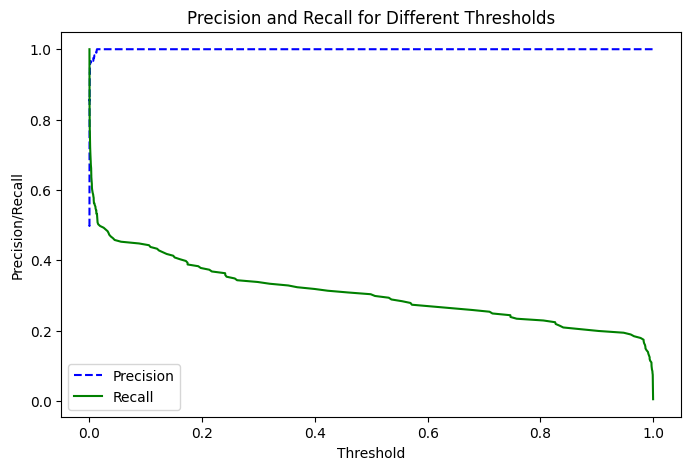

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming 'probabilities' contains the output of model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.title('Precision and Recall for Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [27]:
# Calculate F1 score to find the best balance
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]
optimal_precision = precisions[max_f1_index]
optimal_recall = recalls[max_f1_index]
print("Optimal Threshold:", optimal_threshold)
print("Optimal Precision:", optimal_precision)
print("Optimal Recall:", optimal_recall)


Optimal Threshold: 0.00019432225105327103
Optimal Precision: 0.8578680203045685
Optimal Recall: 0.8407960199004975


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd

def adapted_one_class_learning(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Split data into Majority (normal) and Minority (anomalies)
    X_majority = X[y == 0]
    X_minority = X[y == 1]

    # Splitting majority for training; testing on a combination of majority and minority
    X_train, X_test_majority = train_test_split(X_majority, test_size=0.2, random_state=42)
    _, X_test_minority = train_test_split(X_minority, test_size=0.9, random_state=42)
    X_test = np.vstack([X_test_majority, X_test_minority])
    y_test = np.array([0] * len(X_test_majority) + [1] * len(X_test_minority))

    results = []

    # Initialize classifiers
    classifiers = {
        'Isolation Forest': IsolationForest(contamination=0.01),
        'K-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        print(clf)
        if clf_name == 'Isolation Forest':
            clf.fit(X_train)
            scores = clf.decision_function(X_test)
        else:
            clf.fit(X_train, np.zeros(len(X_train)))  # Training only on majority
            if hasattr(clf, 'decision_function'):
                scores = clf.decision_function(X_test)
            elif hasattr(clf, 'predict_proba'):
                scores = clf.predict_proba(X_test)[:, 1]
            else:
                scores = clf.predict(X_test)
        
        # Adjust for classifiers that output lower scores for anomalies
        if clf_name not in ['Isolation Forest']:
            scores = -scores  # Inverting scores because higher should mean more anomalous

        precision, recall, thresholds = precision_recall_curve(y_test, scores)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]

        predictions = scores > optimal_threshold
        results.append({
            'Classifier': clf_name,
            'Optimal Threshold': optimal_threshold,
            'Class 1 Recall': recall_score(y_test, predictions, pos_label=1),
            'Class 1 Precision': precision_score(y_test, predictions, pos_label=1),
            'Confusion Matrix': confusion_matrix(y_test, predictions).tolist()
        })

    return pd.DataFrame(results)

# Example usage
results_df = adapted_one_class_learning(df, 'Class')
print(results_df)

IsolationForest(contamination=0.01)


c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\murta\AppData\Local\Temp\ipykernel_10740\3638657102.py:55: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KNeighborsClassifier()


IndexError: index 1 is out of bounds for axis 1 with size 1

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd

def adapted_one_class_learning(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Split data into Majority (normal) and Minority (anomalies)
    X_majority = X[y == 0]
    X_minority = X[y == 1]

    # Splitting majority for training; testing on a combination of majority and minority
    X_train, X_test_majority = train_test_split(X_majority, test_size=0.2, random_state=42)
    _, X_test_minority = train_test_split(X_minority, test_size=0.9, random_state=42)
    X_test = np.vstack([X_test_majority, X_test_minority])
    y_test = np.array([0] * len(X_test_majority) + [1] * len(X_test_minority))

    results = []

    # Initialize classifiers
    classifiers = {
        'Isolation Forest': IsolationForest(contamination=0.01),
        'K-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': GaussianNB()
    }

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, np.zeros(len(X_train)))  # Training only on majority

        if clf_name == 'Isolation Forest':
            scores = clf.decision_function(X_test)
        elif hasattr(clf, 'predict_proba'):
            probas = clf.predict_proba(X_test)
            if probas.shape[1] > 1:
                scores = probas[:, 1]  # Probability for minority class
            else:
                # If only one column, take the complement as anomaly score
                scores = 1 - probas[:, 0]
        else:
            scores = clf.predict(X_test)
        
        precision, recall, thresholds = precision_recall_curve(y_test, scores)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]

        predictions = scores > optimal_threshold
        results.append({
            'Classifier': clf_name,
            'Optimal Threshold': optimal_threshold,
            'Class 1 Recall': recall_score(y_test, predictions, pos_label=1),
            'Class 1 Precision': precision_score(y_test, predictions, pos_label=1),
            'Confusion Matrix': confusion_matrix(y_test, predictions).tolist()
        })

    return pd.DataFrame(results)

# Example usage
results_df = adapted_one_class_learning(df, 'Class')
print(results_df)


c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\murta\AppData\Local\Temp\ipykernel_8920\3888545749.py:52: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

print("Precision on Test Set:", precision_score(y_test, predictions))
print("Recall on Test Set:", recall_score(y_test, predictions))
print("F1 Score on Test Set:", f1_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))


Precision on Test Set: 0.8571428571428571
Recall on Test Set: 0.835820895522388
F1 Score on Test Set: 0.8463476070528968
Confusion Matrix:
 [[174  28]
 [ 33 168]]


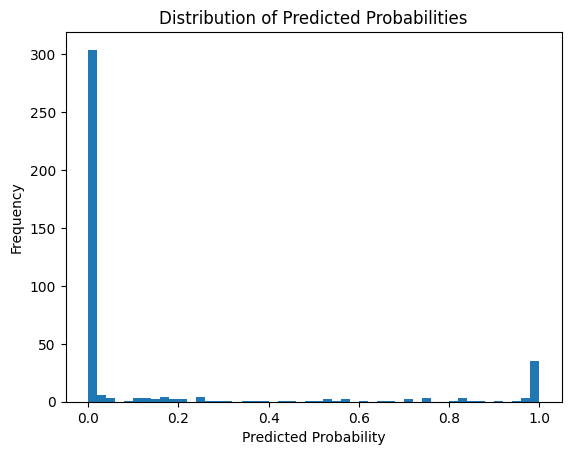

In [29]:
import matplotlib.pyplot as plt

plt.hist(probabilities, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()
